Grid the data. Then have the slices be moving out tangentally from the shoreline...

# File Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import stat
import itertools
import geopandas as gpd
from datetime import datetime
import shapely 
from shapely.geometry import LineString, shape
import folium
from colormap import rgb2hex
from folium.plugins import FloatImage

# Load the Data

In [2]:
# Load the data using geopandas

proxies = [
    r'TOB',
    r'VL',
    r'WM'
]

atolls = [
    'Nanumea',
    'Nanumaga'
]

locations_dict = {
    'Nanumea':[-5.667723, 176.094928],
    'Nanumaga':[-6.287944, 176.321295]
}

combinations = list(itertools.product(atolls,proxies))

# Define the years the shoreline change datafile is for. This is atoll specific
years_dict = {
    'Nanumea':'2003_2021',
    'Nanumaga':'2003_2020'
}

geopandas_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    geopandas_dict.update({
        (atoll,proxy):gpd.read_file('Preprocessed_datasets/Shoreline_shapefiles/{}/{}_{}_{}.shp'.format(proxy,atoll,proxy,year)).rename(columns={'Layer':'layer','Area':'area','Perimeter':'perimeter'})
    })



In [3]:

def shoreline_map(atoll,proxy):
    
    gdf_test = geopandas_dict[atoll,proxy].copy()
    
    # Correct some typos
    gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'
    
    gdf_test['layer'] = gdf_test['layer'].fillna(value=1)
    gdf_test['id'] = gdf_test['id'].fillna(value=1)
    
    # Convert polygons to linestrings if there are any
    if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
        gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
    
    view = 'Satellite'
    location = locations_dict[atoll]
    if view == 'Map':
        map_osm = folium.Map(location=location,zoom_start=11)
    elif view == 'Satellite':
        token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
        tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

        map_osm = folium.Map(location=location, zoom_start=40, tiles=tileurl, attr='Mapbox')

    years_list = []
    for layer,group in gdf_test.groupby('layer'):
        if (proxy=='VL')&(atoll!='Nanumaga'):
            year = int(layer.split('_')[1])
        else:
            year = int(layer.split('_')[-1])
        years_list.append(year)

    ids = np.unique(gdf_test['id'])

    len_years = len(years_list)
    print(years_list)
    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len_years,1/(len_years-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len_years,1)}

    colors_hex_points = [colour_hex_dict[x] for x in np.arange(0,len_years,1)]

    output_list = []

    i = 0
    for layer,group in gdf_test.groupby('layer'):
        folium.Choropleth(
            group,
            line_color=colors_hex_points[i]
        ).add_to(map_osm)

        output = plt.Line2D([],[],c=colours_rgb[i])
        output_list.append(output)

        i+=1

    legend = plt.legend(output_list,years_list,title='Year',fontsize=10,ncol=3)
    plt.setp(legend.get_title(),fontsize=12)
    plt.axis('off')
    plt.savefig('legend.png')
    plt.close()
    url = (
        "legend.png"
    )    
    FloatImage(url, bottom=55, left=55).add_to(map_osm)
    print(atoll,proxy)
    
    return(map_osm)

In [4]:
shoreline_map('Nanumea','TOB')

[2003, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Nanumea TOB


In [5]:
shoreline_map('Nanumea','WM')

[2003, 2005, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Nanumea WM


In [6]:
shoreline_map('Nanumea','VL')

[1971, 1984, 2003, 2005, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Nanumea VL


In [7]:
shoreline_map('Nanumaga','TOB')

[2003, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Nanumaga TOB


In [8]:
shoreline_map('Nanumaga','WM')

[2003, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Nanumaga WM


In [9]:
shoreline_map('Nanumaga','VL')

[1971, 1984, 2003, 2004, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Nanumaga VL


# Gridding the Data

In [10]:
atoll = 'Nanumaga'
proxy = 'WM'

gdf_test = geopandas_dict[atoll,proxy].copy()

# Correct some typos
gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'

gdf_test['layer'] = gdf_test['layer'].fillna(value=1)
gdf_test['id'] = gdf_test['id'].fillna(value=1)

# Convert polygons to linestrings if there are any
if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
    gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]

In [11]:
dict_of_df_xy = {}

for row,linestring in gdf_test.geometry.iteritems():
    linestring = gdf_test.loc[0,'geometry']
    XY_list = [(x,y) for x,y in linestring.coords]
    df_xy = pd.DataFrame(XY_list)
    df_xy.columns = ['lon','lat']
    
    dict_of_df_xy.update({
        row:df_xy
    })
    
df_xy = pd.concat(dict_of_df_xy)

df_xy = df_xy.reset_index().rename(columns={'level_0':'year_ix'}).drop('level_1',axis=1)

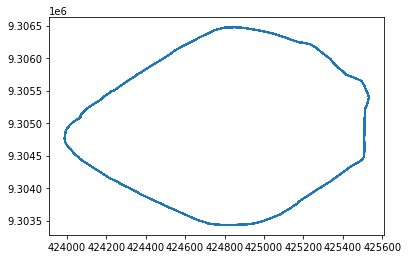

In [12]:
plt.plot(df_xy.lon,df_xy.lat)

## Create a grid

In [13]:
lon_min = np.min(df_xy.lon)
lat_min = np.min(df_xy.lat)

lon_max = np.max(df_xy.lon)
lat_max = np.max(df_xy.lat)

In [14]:

lon_grid = np.arange(lon_min,lon_max,(lon_max-lon_min)/20)
lat_grid = np.arange(lat_min,lat_max,(lat_max-lat_min)/20)

In [15]:
zero_array = np.zeros((len(lon_grid),len(lat_grid)))

In [16]:
import xarray as xr

In [17]:
zero_array = xr.DataArray(zero_array,coords=(lon_grid,lat_grid),dims=('lon','lat'))

# Plotting

In [18]:
df_xy

,year_ix,lon,lat
0,0,424804.160398,9.303432e+06
1,0,424793.510919,9.303433e+06
2,0,424770.889044,9.303436e+06
3,0,424748.002585,9.303441e+06
4,0,424714.929669,9.303456e+06
...,...,...,...
2665,14,424929.705190,9.303447e+06
2666,14,424910.258315,9.303439e+06
2667,14,424885.387481,9.303436e+06
2668,14,424846.096856,9.303434e+06


In [19]:


for index,row in df_xy.iterrows():
    lon_idx = min(range(len(lon_grid)), key=lambda i: abs(lon_grid[i]-row.lon))
    lat_idx = min(range(len(lat_grid)), key=lambda i: abs(lat_grid[i]-row.lat))

    zero_array[lat_idx,lon_idx] = 1

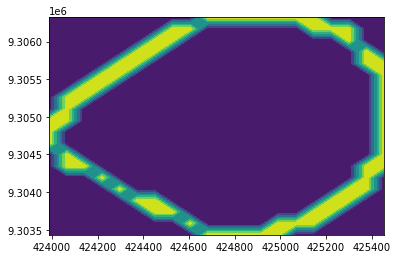

In [20]:
plt.contourf(zero_array.lon,zero_array.lat,zero_array)

# Voxel

In [21]:
def getVoxelTraversalPts(strPt, endPt, geom):
  Max_Delta = 1000000.0
  #origin
  x0 = geom[0]
  y0 = geom[3]

  (sX, sY) = (strPt[0], strPt[1])
  (eX, eY) = (endPt[0], endPt[1])
  dx = geom[1]
  dy = geom[5]

  sXIndex = ((sX - x0) / dx)
  sYIndex = ((sY - y0) / dy)
  eXIndex = ((eX - sXIndex) / dx) + sXIndex
  eYIndex = ((eY - sYIndex) / dy) + sYIndex

  deltaX = float(eXIndex - sXIndex)
  deltaXSign = 1 if deltaX > 0 else -1 if deltaX < 0 else 0
  stepX = deltaXSign

  tDeltaX = min((deltaXSign / deltaX), Max_Delta) if deltaXSign != 0 else Max_Delta
  maxX = tDeltaX * (1 - sXIndex + int(sXIndex)) if deltaXSign > 0 else tDeltaX * (sXIndex - int(sXIndex))

  deltaY = float(eYIndex - sYIndex)
  deltaYSign = 1 if deltaY > 0 else -1 if deltaY < 0 else 0
  stepY = deltaYSign

  tDeltaY = min(deltaYSign / deltaY, Max_Delta) if deltaYSign != 0 else Max_Delta
  maxY = tDeltaY * (1 - sYIndex + int(sYIndex)) if deltaYSign > 0 else tDeltaY * (sYIndex - int(sYIndex))

  x = sXIndex
  y = sYIndex

  ptsIndexes = []
  pt = [round(x), round(y)]
  ptsIndexes.append(pt)
  prevPt = pt
  while True:
    if maxX < maxY:
        maxX += tDeltaX
        x += deltaXSign
    else:
        maxY += tDeltaY
        y += deltaYSign

    pt = [round(x), round(y)]
    if pt != prevPt:
        #print pt
        ptsIndexes.append(pt)
        prevPt = pt

    if maxX > 1 and maxY > 1:
        break

  return (ptsIndexes)